# Video Classification Project

The University of Central Florida provides a dataset of short videos for the purpose of training video classifiers to recognize actions in videos. More info can be found here: https://www.crcv.ucf.edu/data/UCF101.php 

The project has two parts: 
1. In the first part I use this tutotial https://keras.io/examples/vision/video_classification/ for guidance on making a CNN-RNN Architecture model to classify the videos

2. In the second part I use MobileNetV3 Small to classify frames in the videos to match the video type they belong to

In the short time I had to do this project, I was able to get the MobileNetV3 Small model to work much better than the CNN-RNN model. The MobileNetV3 Small model had a weighted average recall, precision, and f1-score of 0.94 on the test data.

## Download the dataset

In [1]:
!pip install -q git+https://github.com/tensorflow/docs

In [2]:
!wget -q https://git.io/JGc31 -O ucf101_top5.tar.gz
!tar xf ucf101_top5.tar.gz

## Import Libraries

In [3]:
from tensorflow_docs.vis import embed
from tensorflow import keras
from imutils import paths
from sklearn.utils import shuffle
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import imageio
import cv2
import os

## Define Hyperparameters

In [4]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 10

MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048

## Prepare the Data

In [5]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

train_df.sample(10)

Total videos for training: 594
Total videos for testing: 224


,video_name,tag
539,v_TennisSwing_g17_c01.avi,TennisSwing
319,v_Punch_g19_c07.avi,Punch
94,v_CricketShot_g22_c03.avi,CricketShot
559,v_TennisSwing_g20_c02.avi,TennisSwing
585,v_TennisSwing_g24_c04.avi,TennisSwing
68,v_CricketShot_g17_c06.avi,CricketShot
186,v_PlayingCello_g18_c03.avi,PlayingCello
333,v_Punch_g22_c03.avi,Punch
284,v_Punch_g14_c06.avi,Punch
213,v_PlayingCello_g22_c04.avi,PlayingCello


### Making Helper Functions 

In [6]:
'''
Crops the frame into a square with an edge 
length equal to the smallest dimension
'''
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]

'''
Turns the video into a list of cropped and resized frames
'''
def load_video(path, max_frames=0, 
               frame_red_factor=1, 
               resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        i = 0
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            if(i%frame_red_factor == 0):
               frame = crop_center_square(frame)
               frame = cv2.resize(frame, resize)
               frame = frame[:, :, [2, 1, 0]]
               frames.append(frame)
               i+=1

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

In [7]:
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["tag"])
)
print(label_processor.get_vocabulary())

['CricketShot', 'PlayingCello', 'Punch', 'ShavingBeard', 'TennisSwing']


In [8]:
'''
Plot the training and validation accuracies from each epoch during the 
model training.
'''
def plot_accuracy(history):

    N = len(history.history["accuracy"])

    plt.figure(figsize = (7, 7))

    plt.plot(np.arange(0, N), 
             history.history["accuracy"], 
             label = "train_accuracy", 
             ls = '--'
             )

    plt.plot(np.arange(0, N), 
             history.history["val_accuracy"], 
             label = "val_accuracy", 
             ls = '--'
             )

    plt.title("Accuracy vs Epoch")
    
    plt.xlabel("Epochs")
    
    plt.ylabel("Accuracy")
    
    plt.legend(loc="upper left")

In [30]:
def evaluate_model(model, test_data, test_labels):
  
  accuracy = model.evaluate(test_data, test_labels, verbose = 1)
  print('\n', 'Test_Accuracy:-', accuracy[1],'\n')

  pred = model.predict(test_data)

  pred = np.argmax(pred, axis = 1) 
  y_true = test_labels

  # Printing the classification report
  print(classification_report(y_true, pred, target_names=label_processor.get_vocabulary()))

  # Plotting the heatmap using confusion matrix
  cm = confusion_matrix(y_true, pred)

  plt.figure(figsize = (8, 5))

  sns.heatmap(cm, annot = True,  fmt = '.0f', 
              xticklabels=label_processor.get_vocabulary(), 
              yticklabels=label_processor.get_vocabulary()
              )

  plt.ylabel('Actual')

  plt.xlabel('Predicted')

  plt.show()  

## CNN-RNN Architecture
In this approach we are using a CNN-RNN Architecture to transform the frames of a video into features using the InceptionV3 pretrained model. Then we will train an RNN on those features to create a model that can predict the action occuring in the video based on the sequence of features in those frames.

In [10]:
'''
Builds the CNN portion of the model using the InceptionV3 pretrained model
'''
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

In [11]:
'''
Turns the videos into frames of the same shape and runs them through the 
feature extractor
'''
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    labels = label_processor(labels[..., None]).numpy()

    # `frame_masks` and `frame_features` are what we will feed to our 
    #  sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    #  masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        # frames = load_video(os.path.join(root_dir, path))
        frames = load_video(
            os.path.join(root_dir, path), 
            max_frames=0, 
            frame_red_factor=1)
        frames = frames[None, ...]

        # Initialize placeholders to store the masks and features of the 
        # current video.
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels


train_data, train_labels = prepare_all_videos(train_df, "train")
test_data, test_labels = prepare_all_videos(test_df, "test")

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 33ms/step
Frame features in train set: (594, 20, 2048)
Frame masks in train set: (594, 20)


In [12]:
# Utility for our sequence model.
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.GRU(16, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return rnn_model


# Utility for running experiments.
def run_experiment():
    filepath = "/tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_split=0.3,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model


history, sequence_model = run_experiment()

Epoch 1/10
10/13 [======================>.......] - ETA: 0s - loss: 1.4906 - accuracy: 0.3344
Epoch 1: val_loss improved from inf to 1.79478, saving model to /tmp/video_classifier
13/13 [==============================] - 9s 198ms/step - loss: 1.4664 - accuracy: 0.3446 - val_loss: 1.7948 - val_accuracy: 0.3408
Epoch 2/10
11/13 [========================>.....] - ETA: 0s - loss: 1.1415 - accuracy: 0.6562
Epoch 2: val_loss did not improve from 1.79478
13/13 [==============================] - 0s 18ms/step - loss: 1.1169 - accuracy: 0.6747 - val_loss: 1.9682 - val_accuracy: 0.3128
Epoch 3/10
10/13 [======================>.......] - ETA: 0s - loss: 1.0276 - accuracy: 0.7375
Epoch 3: val_loss did not improve from 1.79478
13/13 [==============================] - 0s 17ms/step - loss: 1.0184 - accuracy: 0.7518 - val_loss: 1.9572 - val_accuracy: 0.3017
Epoch 4/10
11/13 [========================>.....] - ETA: 0s - loss: 0.8913 - accuracy: 0.8381
Epoch 4: val_loss did not improve from 1.79478
13/13 

### Evaluating the CNN-RNN performance

Test video path: v_CricketShot_g02_c02.avi
1/1 [==============================] - 0s 18ms/step
  CricketShot: 29.83%
  ShavingBeard: 24.58%
  Punch: 22.24%
  TennisSwing: 11.93%
  PlayingCello: 11.42%



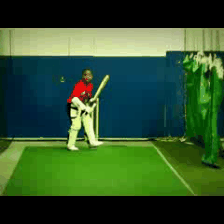

In [27]:
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask


def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("test", path))
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = sequence_model.predict([frame_features, frame_mask])[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames


# This utility is for visualization.
# Referenced from:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")


test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = sequence_prediction(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])

#### Observations: 
* In this case the model correctly predicted the video is of someone taking a cricket shot. 
* However, the probability is pretty low and the next highest choices were shaving beard and punch which probably look much different than this.



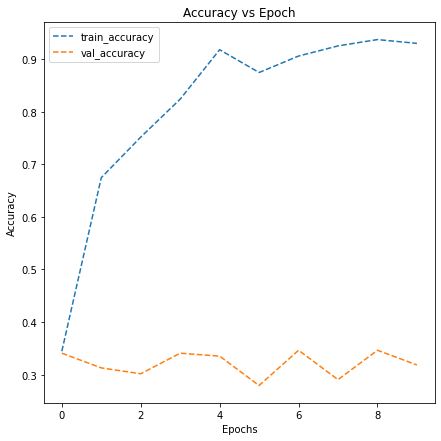

In [14]:
plot_accuracy(history)

#### Observations:
* The validation accuracy is extremely low and the training accuracy is above 90%. This model is badly over fit in its current state

7/7 [==============================] - 0s 7ms/step - loss: 1.4111 - accuracy: 0.5000

 Test_Accuracy:- 0.5 

7/7 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

 CricketShot       0.43      0.71      0.54        49
PlayingCello       0.00      0.00      0.00        44
       Punch       0.85      0.90      0.88        39
ShavingBeard       0.41      0.98      0.58        43
 TennisSwing       0.00      0.00      0.00        49

    accuracy                           0.50       224
   macro avg       0.34      0.52      0.40       224
weighted avg       0.32      0.50      0.38       224



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


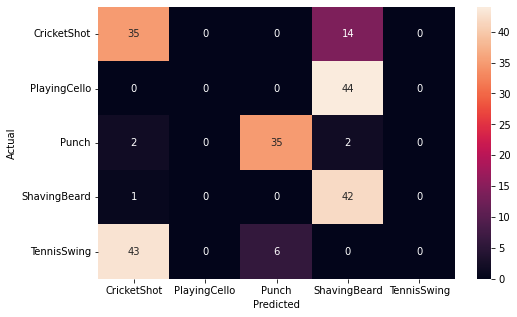

In [31]:
evaluate_model(sequence_model, test_data=test_data, test_labels=test_labels)

#### Observations: 
* This model performs poorly overall. Most likely due to overfitting. 
* The model never predicts 'PlayingCello' or 'TennisSwing' on the test data. 
* The model seems to classify 'Punch' videos the most corrextly with an f1-score of 0.88

## MobileNetV3Small
In this approach we are focused on classifying individual frames to the action video they came from. To do this, we are using the pretrained model MobileNetV3 Small to transform frames into feature and a Sequential model to fit the features to the frame labels. 


### Build the model

In [16]:
mobilenet = keras.applications.MobileNetV3Small(
    weights="imagenet",
    include_top=False,
    pooling="avg",
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
)

# mobilenet.summary()

In [17]:
transfer_layer = mobilenet.get_layer('avg_pool')

mobilenet.trainable = False

x = keras.layers.Flatten()(transfer_layer.output)
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)

x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)

pred = keras.layers.Dense(5, activation='softmax')(x)

mobilenet_model = keras.Model(inputs=mobilenet.input, outputs=pred)

In [18]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor = 'val_loss', save_best_only = True)]

In [19]:
mobilenet_model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy",
                    metrics=['accuracy'])

### Make frames from the videos

In [20]:
def make_frames(df,root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    labels = label_processor(labels[..., None]).numpy()

    frame_data = []
    label_data = []

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(
            os.path.join(root_dir, path), 
            max_frames=30, 
            frame_red_factor=10)

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            frame_data.append(batch)
            label_data.append(labels[idx])

    return np.array(frame_data), np.array(label_data)

### Prepare the frames for training

In [21]:
train_data_mn, train_labels_mn = make_frames(train_df, "train")
test_data_mn, test_labels_mn = make_frames(test_df, "test")

In [22]:
X, y = shuffle(train_data_mn, train_labels_mn)

In [23]:
history_mobilenet = mobilenet_model.fit(X, y,
                            batch_size=16,
                            validation_split=0.2,
                            epochs=10,
                            verbose=1,
                            callbacks=callbacks)

Epoch 1/10
30/30 [==============================] - 6s 71ms/step - loss: 0.2907 - accuracy: 0.8989 - val_loss: 0.1566 - val_accuracy: 0.9412
Epoch 2/10
30/30 [==============================] - 1s 24ms/step - loss: 0.0284 - accuracy: 0.9916 - val_loss: 0.0728 - val_accuracy: 0.9748
Epoch 3/10
30/30 [==============================] - 1s 24ms/step - loss: 0.0254 - accuracy: 0.9937 - val_loss: 0.0290 - val_accuracy: 0.9916
Epoch 4/10
30/30 [==============================] - 1s 24ms/step - loss: 0.0244 - accuracy: 0.9937 - val_loss: 0.0052 - val_accuracy: 1.0000
Epoch 5/10
30/30 [==============================] - 0s 14ms/step - loss: 0.0062 - accuracy: 0.9979 - val_loss: 0.0295 - val_accuracy: 0.9832
Epoch 6/10
30/30 [==============================] - 1s 24ms/step - loss: 0.0192 - accuracy: 0.9916 - val_loss: 9.0353e-04 - val_accuracy: 1.0000
Epoch 7/10
30/30 [==============================] - 0s 14ms/step - loss: 0.0112 - accuracy: 0.9958 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 8/1

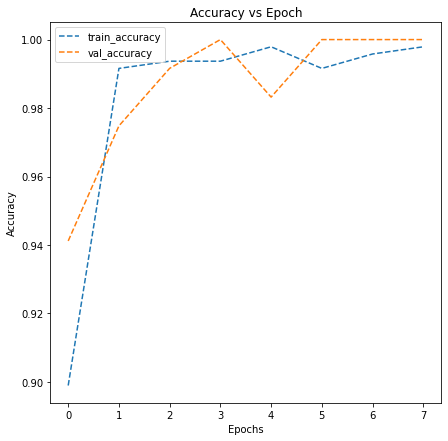

In [24]:
plot_accuracy(history_mobilenet)

#### Observations: 
* The model has very high train and validation accuracies.
* There does not appear to be any overfitting.

7/7 [==============================] - 0s 24ms/step - loss: 0.1422 - accuracy: 0.9375

 Test_Accuracy:- 0.9375 

7/7 [==============================] - 0s 16ms/step
              precision    recall  f1-score   support

 CricketShot       0.94      0.90      0.92        49
PlayingCello       1.00      0.93      0.96        44
       Punch       1.00      0.95      0.97        39
ShavingBeard       0.98      0.98      0.98        43
 TennisSwing       0.82      0.94      0.88        49

    accuracy                           0.94       224
   macro avg       0.95      0.94      0.94       224
weighted avg       0.94      0.94      0.94       224



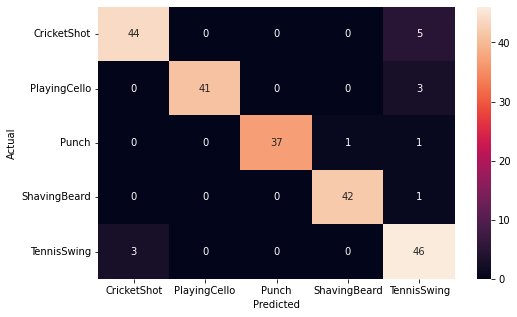

In [32]:
evaluate_model(mobilenet_model, test_data_mn, test_labels_mn)

#### Observations: 
* The model appears to have great performance. Much better than the CNN-RNN Architecture. 
* The most commonly confused classes are 'CricketShot' and 'TennisSwing' which intuitively makes sense to me becuase they seem similar looking

## Conclusion
For this data set, classifying individual frames was much more accurate then classifying sequences of frames. I believe the MobileNetsV3 Small model was able to identify things such as a tennis racket or cricket bat in the scene that helped it make the correct classification. The CNN-RNN model likely struggled because some of the features in the sequences were making similar motions. 

Even though classifying individual frames was more successful in this instance, that will not always be the case. The dataset we used has videos with drastically different backgrounds and items in the scene. Tennis looks much different than shaving. However, if we had to analyze videos with similar backgrounds and items, such as video of an entire surgery, we may need to upgrade to a sequence model in order to train a model that can more accurately classify the actions in the scene.